In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.stats import sem


**Load in data**

In [4]:
#load in the data from the variables sheet
variables = pd.read_excel('Balgoma_data.xlsx', sheet_name='Variables', index_col=0)
    #clean up the variables dataframe by isolating tissue and family columns while also removing all NAN/NA
variables = variables[['Tissue','family']].dropna()

#load in the data from the signal sheet
signal = pd.read_excel('Balgoma_data.xlsx', sheet_name='Signal', index_col=0)

**Figure2B - Loadings of the prinicpal component analysis of the jejunal and hepatic lipidomes**

Initializing necessary variables

In [5]:
#seperate variables data by tissue type
    #isolate the variables that are liver tissue
liver_vars = variables[variables['Tissue'] == 'Liver'].index.tolist()
    #get the index of these variables
liver_ix = variables.index.get_indexer(liver_vars).tolist()

    #isolate the variables that are jejunum tissue
jejunum_vars = variables[variables['Tissue'] == 'Jejunum'].index.tolist()
    #get the index of these variables
jejunum_ix = variables.index.get_indexer(jejunum_vars).tolist()

#isolate the family column of variables only but keep the index
family_col = variables[['family']]
    #change the row names to index
family_col = family_col.reset_index(drop = True)

#initialize a new dataframe for the signal data so we do not modify the original
working_signal = signal

#initialize the number of components
num_comp = 2

#initialize PCA with the number of components
pca = PCA(n_components = num_comp)

Processing, perform, and isolation of PCA loading data

In [7]:
#standardize the data
scaler = StandardScaler()
working_signal = scaler.fit_transform(working_signal)

#perform PCA
pca_result = pca.fit_transform(working_signal)

#get the loading data from pca
pca_loading = pca.components_

#convert flipped loading data into a dataframe to produce graph
pca_loading_df = pd.DataFrame(pca_loading.T, columns = [f'PC{i+1}' for i in range(num_comp)])

Visualization

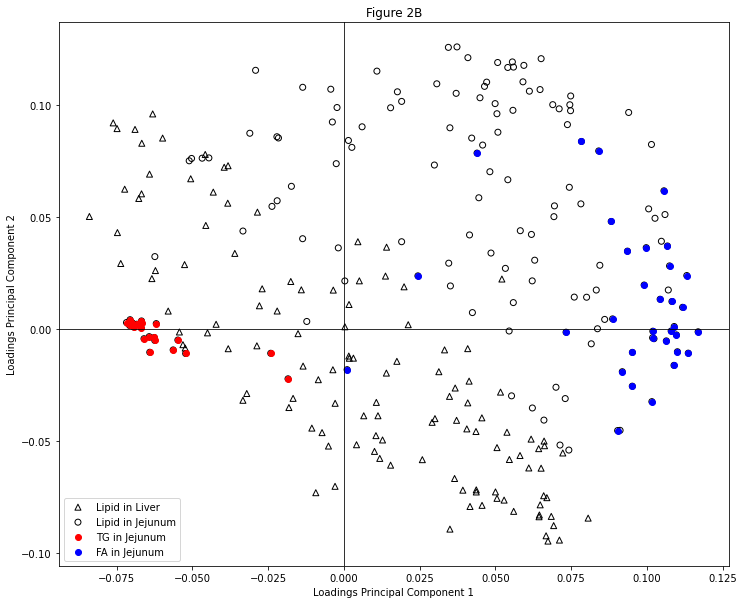

In [8]:
#add the family column to the pca_loading_df
pca_loading_df = pd.concat([pca_loading_df, family_col], axis=1)

#isolate the liver and jejunum data from each other
liver_loading_df = pca_loading_df.loc[liver_ix]
jejunum_loading_df = pca_loading_df.loc[jejunum_ix]

#PLOTTING
#create figure for plotting
fig, ax = plt.subplots(figsize=(12, 10))

#plot 'liver' data with triangles
ax.scatter(liver_loading_df["PC1"], liver_loading_df["PC2"], marker='^', edgecolor='black', facecolor='none', label='liver')

#plot 'jejunum' data with circles
ax.scatter(jejunum_loading_df["PC1"], jejunum_loading_df["PC2"], marker='o', edgecolor='black', facecolor='none', label='jejunum')

#set colors based on the 'family' column of TG and FA
family_colors = {'TG': 'red', 'FA': 'blue'}
for family, color in family_colors.items():
    #get a list of indices of the family
    family_ix = jejunum_loading_df[jejunum_loading_df['family'] == family].index.tolist()
        #isolate these indices from the rest of the dataframe
    family_ix_df = pca_loading_df.loc[family_ix]
    
    #edit the color of these datapoints
    ax.scatter(family_ix_df["PC1"], family_ix_df["PC2"], edgecolor=color, facecolor=color, label=family)

#add lines through the origin
ax.axhline(0, color='black', linewidth=0.8)  # Horizontal line through y=0
ax.axvline(0, color='black', linewidth=0.8)  # Vertical line through x=0

#customize plot labels, legend, etc.
ax.set_title('Figure 2B')
ax.set_xlabel('Loadings Principal Component 1')
ax.set_ylabel('Loadings Principal Component 2')

# Edit the legend
legend_labels = ['Lipid in Liver', 'Lipid in Jejunum', 'TG in Jejunum', 'FA in Jejunum']
ax.legend(legend_labels, loc='lower left')

plt.show()

**Bar Plots - Effect of the treatment in the selected lipids in the jejunum**

Initializing necessary variables

In [9]:
#initialize a new dataframe for the signal data so we do not modify the original
working_signal = signal

#isolate Jejunum variables
    #filter variables to only keep the jejunum tissues
jejunum_rows = variables[variables['Tissue'] == 'Jejunum']
   #isolate the variables that are jejunum tissue
jejunum_vars = jejunum_rows.index.tolist()
    #filter signal to only keep the jejunum tissue variables
jejunum_cols = working_signal[jejunum_vars]

#list of conditions for each bar
conditions = ['Control', 'i.V. 6h', 'i.V. 24h', 'i.V. 72h', 'i.V. 168h', 'i.V. dd 72h', 'i.P. 72h']

#define colors for each bar
colors = ['#ffffff', '#f8eae9', '#ebbfbc', '#dd827d', '#d54838', '#9bb693', '#5166cf']


**Figure4A**

Initializing and calculating nessesary lists

In [11]:
#create lists of variables that corresponds to the target families FA and TG
FA_vars = jejunum_rows[jejunum_rows['family'] == 'FA'].index.tolist()
TG_vars = jejunum_rows[jejunum_rows['family'] == 'TG'].index.tolist()

#create list of variables that correspond to both
FA_TG_vars = FA_vars + TG_vars

#filter jejunum signal to only keep the family
FA_TG_cols = jejunum_cols[FA_TG_vars]

##perform the calculations
    #get the sum of the FA and TG
FA_sum = FA_TG_cols[FA_vars].sum(axis=1)
TG_sum = FA_TG_cols[TG_vars].sum(axis=1)
    #get the ratio of sums
ratio = FA_sum/TG_sum
    #get the log of ratio
log = np.log(ratio)
    #convert completed calculations into dataframe
log_df = pd.DataFrame(log)

#get the x and error data
    #get the means
all_means = log_df.groupby(log_df.index).mean().abs()
    #reset order to conditions
all_means = all_means.reindex(conditions)
    #store all data from column 0 in a list
all_means = all_means[0].tolist()

    #get the standard error of the mean
all_sems = log_df.groupby(log_df.index).sem()
    #reset order to conditions
all_sems = all_sems.reindex(conditions)
    #store all data from column 0 in a list
all_sems = all_sems[0].tolist()

Visualization

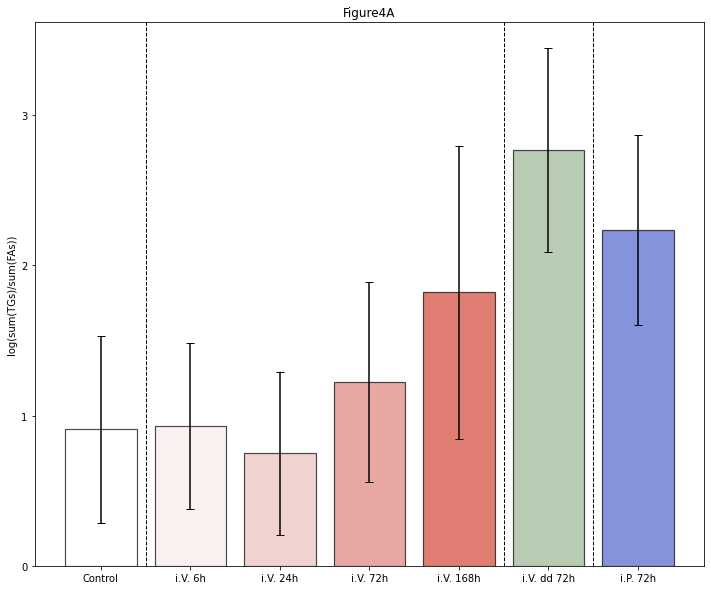

In [12]:
#create a figure with specified size
plt.figure(figsize=(12, 10))

#convert list x, y, and error to NumPy arrays
conditions = np.array(conditions)
means = np.array(all_means)
error = np.array(all_sems)

#define colors for each bar
colors = ['#ffffff', '#f8eae9', '#ebbfbc', '#dd827d', '#d54838', '#9bb693', '#5166cf']

#plot a bar graph with error bars
plt.bar(conditions, means, yerr = error, color=colors, alpha=0.7, edgecolor='black', linewidth=1.2, capsize=4)

#add dashed lines
plt.axvline(0 + 0.5, color='black', linestyle='dashed', linewidth=1)
plt.axvline(4 + 0.5, color='black', linestyle='dashed', linewidth=1)
plt.axvline(5 + 0.5, color='black', linestyle='dashed', linewidth=1)

#customize the y-axis ticks
plt.yticks(np.arange(0, 4, 1))

#adding label and title
plt.ylabel('log(sum(TGs)/sum(FAs))')
plt.title('Figure4A')

#display the plot
plt.show()

**Figure4B**

Initializing and calculating nessesary lists

In [13]:
#create a list of variables that corresponds to the target familiy etherPE
etherPE_vars = jejunum_rows[jejunum_rows['family'] == 'etherPE'].index.tolist()

#filter jejunum signal to only keep the family
etherPE_cols = jejunum_cols[etherPE_vars]

##perform the calculations
    #get the sum of etherPE
etherPE_sum = etherPE_cols[etherPE_vars].sum(axis=1)

#get the x and error data
    #get the means
all_means = etherPE_sum.groupby(etherPE_sum.index).mean().abs()
    #reset order to conditions
all_means = all_means.reindex(conditions)
    #store all data from column 0 in a list
all_means = all_means.tolist()

    #get the standard error of the mean
all_sems = etherPE_sum.groupby(etherPE_sum.index).sem()
    #reset order to conditions
all_sems = all_sems.reindex(conditions)
    #store all data from column 0 in a list
all_sems = all_sems.tolist()

Visualization

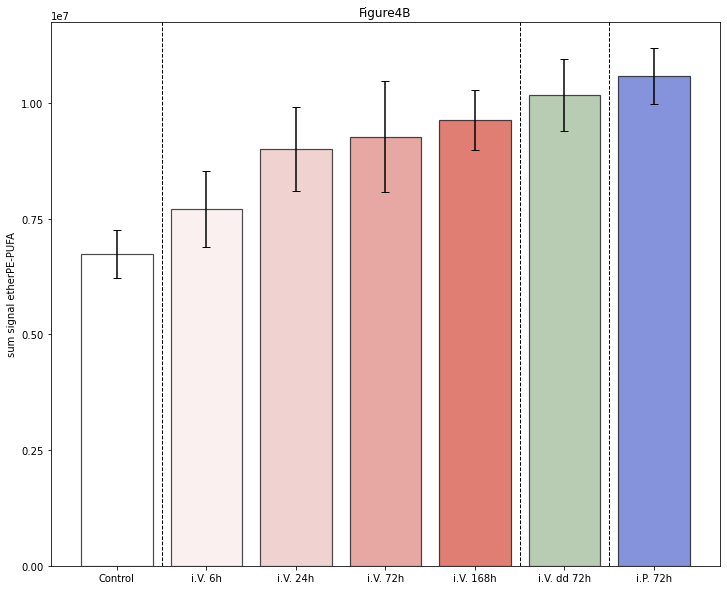

In [14]:
#create a figure with specified size
plt.figure(figsize=(12, 10))

#convert list x, y, and error to NumPy arrays
conditions = np.array(conditions)
means = np.array(all_means)
error = np.array(all_sems)

#plot a bar graph with error bars
plt.bar(conditions, means, yerr = error, color=colors, alpha=0.7, edgecolor='black', linewidth=1.2, capsize=4)

#add dashed lines
plt.axvline(0 + 0.5, color='black', linestyle='dashed', linewidth=1)
plt.axvline(4 + 0.5, color='black', linestyle='dashed', linewidth=1)
plt.axvline(5 + 0.5, color='black', linestyle='dashed', linewidth=1)

#customize the y-axis ticks
plt.yticks(np.arange(0, 1.25e7, 2.5e6))

#adding label and title
plt.ylabel('sum signal etherPE-PUFA')
plt.title('Figure4B')

#display the plot
plt.show()